## Classification and Differencing of Two Canopy Height Models for the Teakettle Experimental Watershed

The goal of this program is to read in a pre- and post-burn canopy height model, classify them by height, and perform a change detection.   
This program requires Point Data Abstraction Library (PDAL) and Python 3.5 to run.

Nicole Abib nicole.abib@duke.edu   
NEON Data Institute 2018

Install PDAL in commmand line
*conda install -c conda-forge pdal python-pdal*

In [1]:
# Check python version
import sys
sys.version

'3.5.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:11:22) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
# Import required libraries
import numpy as np
import numpy.ma as ma
import gdal, osr, copy
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Load Labeeb's pipeline code and python script (something.txt)

The Digital Terrain Model created above has holes where no discrete lidar returns reached the ground. There are many reasons this could happen, such as dense tree canopy or water present on the ground.

In [ ]:
# Create an inverse raster from Digital Terrain Model and Digital Surface Model Model
gdal_calc.py -A crop.tif —outfile=outfile.tif —calc=“1=(A=nodatavalue)" —NoDataValue=-9999

GDAL's fillnodata algorithm will interpolate values in nodata areas using the surrounding pixels. For each pixel a four direction conic search is done to find values to interpolate from (using inverse distance weighting). Once all values are interpolated, zero or more smoothing iterations (3x3 average filters on interpolated pixels) are applied to smooth out artifacts.

In [ ]:
# Fill holes in Digital Terrain Model (DTM) with inverse raster created in previous step
gdal_fillnodata infile.tif outfile.tif -of GTiff

In [3]:
# %load ../functions/neon_aop_lidar_python_functions/raster2array.py
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]
    
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    
    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
              
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
    
    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = float(dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']))
            band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

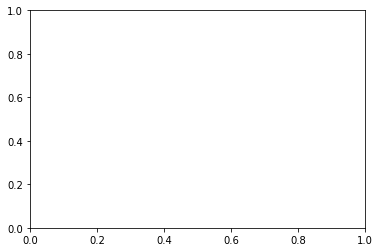

In [4]:
# %load '/Users/nabib/Documents/RSDI-2018/functions/neon_aop_lidar_python_functions/plot_spatial_array.py'
def plot_spatial_array(band_array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(band_array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

In [5]:
# Load in Digital Terrain Model
teak_dtm_array, teak_dtm_metadata = raster2array('/Users/nabib/Documents/RSDI-2018/data/Day2_LiDAR_Intro/NEON_D02_SERC_DP3_368000_4306000_CHM.tif')

[[16.51000023 16.82999992 16.54999924 ...  0.          0.
   0.        ]
 [11.81999969 14.68999958 14.40999985 ...  0.          0.
   0.        ]
 [12.01000023 12.81000042  3.18000007 ...  0.          0.
   0.        ]
 ...
 [27.30999947 26.87000084 26.64999962 ...  0.          0.
   0.        ]
 [26.71999931 27.11000061 27.11000061 ...  0.          0.
   0.        ]
 [26.87999916 27.05999947 27.12999916 ...  0.          0.
   0.        ]]


ValueError: Colormap  is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

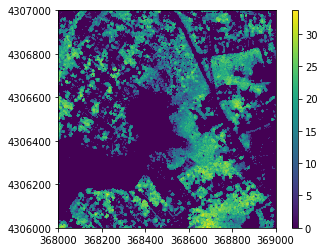

In [10]:
# Create a mask removing values with data
teak_dtm_nan = copy.copy(teak_dtm_array)
teak_dtm_nan[teak_dtm_array == np.nan] =1
print(teak_dtm_nan)

plot_spatial_array(teak_dtm_nan,
                   teak_dtm_metadata['extent'],
                   [np.min(teak_dtm_nan),np.max(teak_dtm_nan)])

Create a Canopy Height Model (CHM) by subtracting the ground returns from the top of canopy returns.

In [ ]:
# Create a canopy height model
teak_chm_pre = gdal_calc -A canopy_pre.tif -B ground.tif -calc "A-B" --outfile teak_chm_pre.tif
teak_chm_post = gdal_calc -A canopy_post.tif -B ground.tif -calc "A-B" --outfile teak_chm_post.tif

In [ ]:
# Create CHM burn difference raster
teak_chm_diff = gdal_calc -A canopy_pre.tif -B canopy_post.tif -calc "B-A" --outfile teak_chm_diff.tif

In [ ]:
# Read in canopy height model GeoTiff
teak_chm = './teak_chm.tif'

In [ ]:
# extract filename for later use
just_chm_file = os.path.basename(teak_chm)
just_chm_file_split = just_chm_file.split(sep="_")

In [ ]:
chm_array, chm_array_metadata = raster2array(teak_chm)

In [ ]:
# Calculate statistics for dataset
chm_stats = chm_array.GetStatistics(True,True)
print('TEAK CHM Statistics: Minimum = %.2f, Maximum = %.2f, Mean = %.3f, StDev = %.3f'
     %(chm_stats[0],chm_stats[1],chm_stats[2],chm_stats[3]))

In [ ]:
# Convert no data values to NaN
chm_array[chm_array == int(noDataVal)]=np.nan

In [ ]:
print(chm_array)

In [ ]:
# Determine the percent NaN and NonZero Data Values
pct_nan = np.count_nonzero(np.isnan(chm_array))/(rows*cols)
print('Percent NaN:',round(pct_nan*100,2))
print('Percent non-zero:',round(100*np.count_nonzero(chm_array)/(rows*cols),2))

In [ ]:
# Plot Canopy Height Model (CHM)
plt.figure(1)

plot_spatial_array(chm_array,
                   chm_array_metadata['extent'], 
                   colorlimit = [np.min(chm_array),np.max(chm_array)],
                   title='TEAK Canopy Height',
                   cmap_title='Canopy Height (m)'
                   colormap='Greens')

plt.savefig('../output/'+ just_chm_file[0:-4]+'CHM.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

In [ ]:
# Plot a histogram of the canopy height model with 100 bins
plt.hist(chm_array[~np.isnan(chm_array)],100);
ax = plt.gca()
ax.set_ylim([0,15000])
plt.title('Distribution of TEAK Canopy Height')
plt.xlabel('Tree Height (m)')
plt.ylabel('Relative Frequency')

In [ ]:
# Plot Canopy Height Model with heights above 35 meters masked out
plot_spatial_array(chm_array,
                   chm_ext,
                   (0,35),
                   title='TEAK Canopy Height',
                   cmap_title='Canopy Height (m)',
                   colormap = 'Greens')

In [ ]:
# Define array2raster to take array data and output a usable geoTIFF
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


In [ ]:
# run raster2array on chm
array2raster('output_file_path.tiff',(xMin,yMax),1,-1,np.array(chm_array_smooth/10000,dtype=float),32611)

### Threshold Based Raster Classification

In [ ]:
# Classify canopy height model into five 10m classes
chm_reclass = copy.copy(chm_array)
chm_reclass[np.where(chm_array==0)]=1
chm_reclass[np.where((chm_array > 0) &(chm_array <= 10))] = 2
chm_reclass[np.where((chm_array > 10) &(chm_array <= 20))] = 3
chm_reclass[np.where((chm_array > 20) &(chm_array <= 30))] = 4
chm_reclass[np.where(chm_array > 30)] = 5

In [ ]:
# Plot classified canopy height model
import matplotlib.colors as colors
plt.figure()
cmapCHM = colors.ListedColormap(['lightblue','yellow','orange','green','red'])
plt.imshow(chm_reclass,extent=chm_ext,cmap=cmapCHM)
plt.title('TEAK CHM Classification')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

import matplotlib.patches as mpatches
class1_box = mpatches.Patch(color='lightblue', label='CHM = 0m')
class2_box = mpatches.Patch(color='yellow', label='0m < CHM <= 10m')
class3_box = mpatches.Patch(color='orange', label='10m < CHM <= 20m')
class4_box = mpatches.Patch(color='green', label='20m < CHM <= 30m')
class5_box = mpatches.Patch(color='red', label='CHM > 30m')

ax.legend(handles = [class1_box,class2_box,class3_box,class4_box,class5_box], handlelength = 0.7, bbox_to_anchor = (1.05, 0.4),loc='lower left',borderaxespad=0.)


plt.savefig('../output/'+ just_chm_file[0:-4]+'_CHM_classified.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)